The setup will be as follows:

Hidden States (Traffic Conditions):

Free Flow (delivery expected to be fast, < 30 minutes)
Moderate Traffic (delivery with slight delays, 30-60 minutes)
Heavy Traffic (significant delays, > 60 minutes)
Observations (Delivery Times):

Quick Delivery (< 30 minutes)
Moderate Delivery (30-60 minutes)
Slow Delivery (> 60 minutes)

In [18]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
#np.random.seed(42)

# Parameters
n_samples = 1000  # Number of deliveries

# Define hidden states and observed states
hidden_states = ["Free Flow", "Moderate Traffic", "Heavy Traffic"]
observed_states = ["Quick Delivery", "Moderate Delivery", "Slow Delivery"]

# Initial probabilities for hidden states
initial_probs = [0.5, 0.3, 0.2]  # Free Flow, Moderate Traffic, Heavy Traffic

# Transition probability matrix between hidden states
transition_matrix = [
    [0.7, 0.2, 0.1],  # Free Flow to Free Flow, Moderate, Heavy
    [0.3, 0.5, 0.2],  # Moderate to Free Flow, Moderate, Heavy
    [0.2, 0.3, 0.5],  # Heavy to Free Flow, Moderate, Heavy
]

# Emission probability matrix: probabilities of observed times given each traffic state
emission_matrix = {
    "Free Flow": [0.8, 0.15, 0.05],    # Mostly Quick Delivery
    "Moderate Traffic": [0.1, 0.7, 0.2],  # Mostly Moderate Delivery
    "Heavy Traffic": [0.05, 0.25, 0.7],  # Mostly Slow Delivery
}

# Define time ranges for each observed state in minutes
time_ranges = {
    "Quick Delivery": (10, 30),
    "Moderate Delivery": (30, 60),
    "Slow Delivery": (60, 120),
}

# Generate synthetic data
hidden_states_sequence = []
observed_states_sequence = []
delivery_times = []

# Starting hidden state
current_state = np.random.choice(hidden_states, p=initial_probs)

for _ in range(n_samples):
    # Append the current hidden state
    hidden_states_sequence.append(current_state)
    
    # Generate observed state based on current hidden state
    observed_state = np.random.choice(observed_states, p=emission_matrix[current_state])
    observed_states_sequence.append(observed_state)
    
    # Generate a random delivery time within the range for the observed state
    min_time, max_time = time_ranges[observed_state]
    delivery_time = np.random.randint(min_time, max_time)
    delivery_times.append(delivery_time)
    
    # Transition to the next hidden state
    current_state = np.random.choice(hidden_states, p=transition_matrix[hidden_states.index(current_state)])

# Create DataFrame
data = pd.DataFrame({
    "Traffic Condition (Hidden)": hidden_states_sequence,
    "Delivery Time (Observed)": observed_states_sequence,
    "Delivery Duration (Minutes)": delivery_times
})

# Convert observed delivery times to integers for HMM compatibility
observation_map = {"Quick Delivery": 0, "Moderate Delivery": 1, "Slow Delivery": 2}
data["Delivery Time (Observed)"] = data["Delivery Time (Observed)"].map(observation_map)

print(data.head())
print("------------------------------------------------------------")
print(data.tail())

  Traffic Condition (Hidden)  Delivery Time (Observed)  \
0           Moderate Traffic                         1   
1           Moderate Traffic                         1   
2              Heavy Traffic                         2   
3                  Free Flow                         0   
4                  Free Flow                         0   

   Delivery Duration (Minutes)  
0                           57  
1                           33  
2                           74  
3                           24  
4                           17  
------------------------------------------------------------
    Traffic Condition (Hidden)  Delivery Time (Observed)  \
995              Heavy Traffic                         1   
996           Moderate Traffic                         1   
997           Moderate Traffic                         2   
998                  Free Flow                         0   
999           Moderate Traffic                         1   

     Delivery Duration (Minutes

In [10]:
# Split the dataset (80% train, 20% test)
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Prepare the training and test observations for HMM
train_observations = train_data["Delivery Time (Observed)"].values.reshape(-1, 1)
test_observations = test_data["Delivery Time (Observed)"].values.reshape(-1, 1)

In [11]:
from hmmlearn import hmm

model = hmm.MultinomialHMM(n_components=3, n_iter=500, tol=0.001, random_state=42)
model.fit(train_observations)

MultinomialHMM(n_components=3, n_iter=500,
               random_state=RandomState(MT19937) at 0x2E6F433A340, tol=0.001)

In [12]:
# Predict hidden states for train and test sets
train_hidden_states = model.predict(train_observations)
test_hidden_states = model.predict(test_observations)

# Add predictions to the train and test datasets
train_data["Predicted Traffic Condition"] = [hidden_states[i] for i in train_hidden_states]
test_data["Predicted Traffic Condition"] = [hidden_states[i] for i in test_hidden_states]

# Calculate accuracy on the training and test sets
train_accuracy = (train_data["Traffic Condition (Hidden)"] == train_data["Predicted Traffic Condition"]).mean()
test_accuracy = (test_data["Traffic Condition (Hidden)"] == test_data["Predicted Traffic Condition"]).mean()

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 24.38%
Testing Accuracy: 24.00%


C:\Users\JoãoVieitas\AppData\Local\Temp\ipykernel_10032\3119479383.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Predicted Traffic Condition"] = [hidden_states[i] for i in train_hidden_states]
C:\Users\JoãoVieitas\AppData\Local\Temp\ipykernel_10032\3119479383.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Predicted Traffic Condition"] = [hidden_states[i] for i in test_hidden_states]


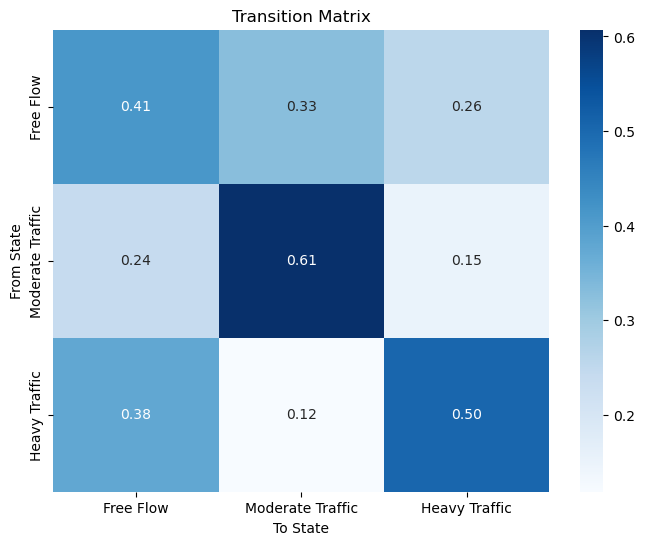

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(model.transmat_, annot=True, fmt=".2f", cmap="Blues", xticklabels=hidden_states, yticklabels=hidden_states)
plt.title("Transition Matrix")
plt.xlabel("To State")
plt.ylabel("From State")
plt.show()


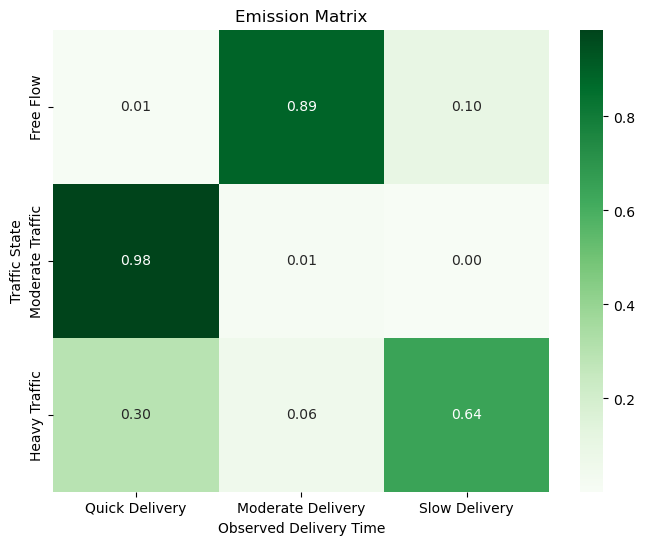

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(model.emissionprob_, annot=True, fmt=".2f", cmap="Greens", xticklabels=observed_states, yticklabels=hidden_states)
plt.title("Emission Matrix")
plt.xlabel("Observed Delivery Time")
plt.ylabel("Traffic State")
plt.show()


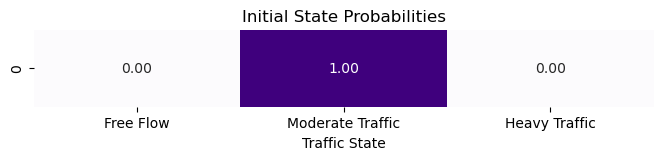

In [15]:
plt.figure(figsize=(8, 1))
sns.heatmap([model.startprob_], annot=True, fmt=".2f", cmap="Purples", xticklabels=hidden_states, cbar=False)
plt.title("Initial State Probabilities")
plt.xlabel("Traffic State")
plt.show()
